# Demo - Adversarial images and attacks with Keras and TensorFlow

In [1]:
# Download the code/images zip file
#!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/basic-image-adversaries/basic-image-adversaries.zip
!unzip -qq basic-image-adversaries.zip
%cd basic-image-adversaries

/home/somnath/Documents/CBS_DL_2022/Lecture-13/Demo/basic-image-adversaries


In [2]:
# import necessary packages
# Copyright (c) 2020 PyImageSearch.com
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import argparse
import imutils #pip install imutils
import json
import cv2 #pip install opencv-python
import os

In [3]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [4]:
### ImageNet class label/index helper utility
def get_class_idx(label):
	# build the path to the ImageNet class label mappings file
	labelPath = os.path.join("pyimagesearch",
		"imagenet_class_index.json")

	# open the ImageNet class mappings file and load the mappings as
	# a dictionary with the human-readable class label as the key and
	# the integer index as the value
	with open(labelPath) as f:
		imageNetClasses = {labels[1]: int(idx) for (idx, labels) in
			json.load(f).items()}

	# check to see if the input class label has a corresponding
	# integer index value, and if so return it; otherwise return
	# a None-type value
	return imageNetClasses.get(label, None)

### Normal image classification without adversarial attacks using Keras and TensorFlow

In [5]:
def preprocess_image(image):
	# swap color channels, preprocess the image, and add in a batch
	# dimension
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = preprocess_input(image)
	image = cv2.resize(image, (224, 224))
	image = np.expand_dims(image, axis=0)

	# return the preprocessed image
	return image

In [6]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "pig.jpg"
}

In [7]:
# load image from disk and make a clone for annotation
print("[INFO] loading image...")
image = cv2.imread(args["image"])
output = image.copy()

# preprocess the input image
output = imutils.resize(output, width=400)
preprocessedImage = preprocess_image(image)

[INFO] loading image...


In [8]:
# load the pre-trained ResNet50 model
print("[INFO] loading pre-trained ResNet50 model...")
model = ResNet50(weights="imagenet")

# make predictions on the input image and parse the top-3 predictions
print("[INFO] making predictions...")
predictions = model.predict(preprocessedImage)
predictions = decode_predictions(predictions, top=3)[0]

[INFO] loading pre-trained ResNet50 model...
[INFO] making predictions...


In [9]:
# loop over the top three predictions
for (i, (imagenetID, label, prob)) in enumerate(predictions):
	# print the ImageNet class label ID of the top prediction to our
	# terminal (we'll need this label for our next script which will
	# perform the actual adversarial attack)
	if i == 0:
		print("[INFO] {} => {}".format(label, get_class_idx(label)))

	# display the prediction to our screen
	print("[INFO] {}. {}: {:.2f}%".format(i + 1, label, prob * 100))

[INFO] hog => 341
[INFO] 1. hog: 99.97%
[INFO] 2. wild_boar: 0.03%
[INFO] 3. piggy_bank: 0.00%


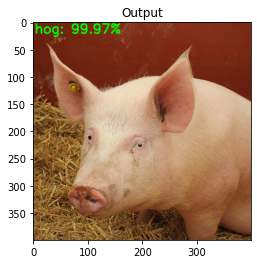

In [10]:
# draw the top-most predicted label on the image along with the
# confidence score
text = "{}: {:.2f}%".format(predictions[0][1],
	predictions[0][2] * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
	(0, 255, 0), 2)

# show the output image
plt_imshow("Output", output)

In [11]:
def preprocess_image(image):
	# swap color channels, resize the input image, and add a batch
	# dimension
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	image = np.expand_dims(image, axis=0)

	# return the preprocessed image
	return image

In [12]:
def clip_eps(tensor, eps):
	# clip the values of the tensor to a given range and return it
	return tf.clip_by_value(tensor, clip_value_min=-eps,
		clip_value_max=eps)

In [13]:
def generate_adversaries(model, baseImage, delta, classIdx, steps=50):
	# iterate over the number of steps
	for step in range(0, steps):
		# record our gradients
		with tf.GradientTape() as tape:
			# explicitly indicate that our perturbation vector should
			# be tracked for gradient updates
			tape.watch(delta)

			# add our perturbation vector to the base image and
			# preprocess the resulting image
			adversary = preprocess_input(baseImage + delta)

			# run this newly constructed image tensor through our
			# model and calculate the loss with respect to the
			# *original* class index
			predictions = model(adversary, training=False)
			loss = -sccLoss(tf.convert_to_tensor([classIdx]),
				predictions)

			# check to see if we are logging the loss value, and if
			# so, display it to our terminal
			if step % 5 == 0:
				print("step: {}, loss: {}...".format(step,
					loss.numpy()))

		# calculate the gradients of loss with respect to the
		# perturbation vector
		gradients = tape.gradient(loss, delta)

		# update the weights, clip the perturbation vector, and
		# update its value
		optimizer.apply_gradients([(gradients, delta)])
		delta.assign_add(clip_eps(delta, eps=EPS))

	# return the perturbation vector
	return delta

In [14]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to original input image")
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output adversarial image")
# ap.add_argument("-c", "--class-idx", type=int, required=True,
# 	help="ImageNet class ID of the predicted label")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"input": "pig.jpg",
    "output": "adversarial.png",
    "class_idx": 341
}

In [15]:
# define the epsilon and learning rate constants
EPS = 2 / 255.0
LR = 0.1

In [16]:
# load the input image from disk and preprocess it
print("[INFO] loading image...")
image = cv2.imread(args["input"])
image = preprocess_image(image)

[INFO] loading image...


In [17]:
# load the pre-trained ResNet50 model for running inference
print("[INFO] loading pre-trained ResNet50 model...")
model = ResNet50(weights="imagenet")

# initialize optimizer and loss function
optimizer = Adam(learning_rate=LR)
sccLoss = SparseCategoricalCrossentropy()

[INFO] loading pre-trained ResNet50 model...


In [18]:
# create a tensor based off of the input image and initialize the
# perturbation vector (we will update this vector via training)
baseImage = tf.constant(image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)

# generate the perturbation vector to create an adversarial example
print("[INFO] generating perturbation...")
deltaUpdated = generate_adversaries(model, baseImage, delta,
	args["class_idx"])

# create the adversarial example, swap color channels, and save the
# output image to disk
print("[INFO] creating adversarial example...")
adverImage = (baseImage + deltaUpdated).numpy().squeeze()
adverImage = np.clip(adverImage, 0, 255).astype("uint8")
adverImage = cv2.cvtColor(adverImage, cv2.COLOR_RGB2BGR)
cv2.imwrite(args["output"], adverImage)

[INFO] generating perturbation...
step: 0, loss: -0.00031144535751082003...
step: 5, loss: -0.0009658439084887505...
step: 10, loss: -0.005242766346782446...
step: 15, loss: -0.06325576454401016...
step: 20, loss: -0.7713549733161926...
step: 25, loss: -3.445319414138794...
step: 30, loss: -7.460117816925049...
step: 35, loss: -13.345356941223145...
step: 40, loss: -21.73526382446289...
step: 45, loss: -30.750934600830078...
[INFO] creating adversarial example...


True

[INFO] running inference on the adversarial example...
[INFO] label: wombat confidence: 100.00%


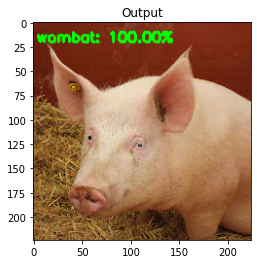

In [19]:
# run inference with this adversarial example, parse the results,
# and display the top-1 predicted result
print("[INFO] running inference on the adversarial example...")
preprocessedImage = preprocess_input(baseImage + deltaUpdated)
predictions = model.predict(preprocessedImage)
predictions = decode_predictions(predictions, top=3)[0]
label = predictions[0][1]
confidence = predictions[0][2] * 100
print("[INFO] label: {} confidence: {:.2f}%".format(label,
	confidence))

# draw the top-most predicted label on the adversarial image along
# with the confidence score
text = "{}: {:.2f}%".format(label, confidence)
cv2.putText(adverImage, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
	(0, 255, 0), 2)

# show the output image
plt_imshow("Output", adverImage)